# Investigating Latent Variable Models as a solution to Causal Overhypotheses

DiBS translates the task of inferring the posterior over Bayesian networks into an inference problem over the continuous latent variable $Z$. This is achieved by modeling the directed acyclic graph $G$ of the Bayesian network using the generative model $p(G | Z)$. The prior $p(Z)$ enforces the acyclicity of $G$.
Ultimately, this allows us to infer $p(G, \Theta | \mathcal{D})$ (and $p(G | \mathcal{D})$) using off-the-shelf inference methods such as Stein Variational gradient descent (SVGD) (Liu and Wang, 2016).

In [31]:
import yaml, pickle
from easydict import EasyDict
from copy import deepcopy

import jax, gym
import jax.random as random
from jax import numpy as jnp
import numpy as np
import igraph
import matplotlib.pyplot as plt
import plotly.express as px
from adjustText import adjust_text

from dibs.target import make_graph_model, Data
from dibs.models import DenseNonlinearGaussian, LinearGaussian
from dibs.utils import visualize_ground_truth, tree

from dibs.inference import MarginalDiBS, JointDiBS

from causal_env_v0 import CausalEnv_v0
from policy import RandomPolicy, FixedInterventionPolicy
from utils import collect_observational_data
from hypotheses import *

In [2]:
key = random.PRNGKey(123)
print(f"JAX backend: {jax.default_backend()}")

key, subk = random.split(key)

JAX backend: gpu


## Constants
* `NUM_SAMPLES` = Number of observation samples to collect
* `NUM_PARTICLES` = Number of particles to use for $Z$
* `N_VARS` = Number of nodes in SCM
* `PARTICLE_DIM` = Dimension of embedding. If `PARTICLE_DIM = N_VARS`, then embedding will be full-rank.

In [7]:
NUM_SAMPLES = 3000
NUM_PARTICLES = 40
N_VARS = 4
PARTICLE_DIM = 4

## Load environment & collect observational data

Define function to collect observational data from environment.

In [8]:
def make_data_env(env: gym.Env, num_samples: int, n_vars: int, env_config: dict, key: jnp.ndarray) -> Data:
    """Collect observational data from environment.

    Args:
        env (gym.Env): Environment to collect data from.
        num_samples (int): Number of samples to collect
        n_vars (int): Number of variables in the environment
        env_config (dict): environment configuration
        key (jnp.ndarray): JAX PRNG key

    Returns:
        Data: Returns a Data object containing the collected data
    """

    # initialize random policy
    random_policy = RandomPolicy(action_space=env.action_space)

    # Create numpy array to store training data
    x = np.zeros((num_samples, n_vars))

    # Define simple method to collect training data
    def store_state(
        *, state, action, next_state, reward, done, info, t_step, store_eps_info
    ) -> None:
        obs = np.concatenate([action, next_state[-1:]]).astype(np.float32) + \
                            np.random.normal(0, 0.1, n_vars)
        assert obs.shape[0] == n_vars, "Observation shape does not match n_vars!"
        x[t_step, :] = obs

    # collect training (observational) data from environment
    collect_observational_data(
        env_config=env_config,
        num_samples=num_samples,
        store_observational_data_callback=store_state,
        store_eps_info=False,
        policy=random_policy,
    )

    # Repeat for holdout & intervention data
    x_ho = np.zeros((num_samples, n_vars))

    def store_state(
        *, state, action, next_state, reward, done, info, t_step, store_eps_info
    ) -> None:
        obs = np.concatenate([action, next_state[-1:]]).astype(np.float32) + \
                            np.random.normal(0, 0.1, n_vars)
        assert obs.shape[0] == n_vars, "Observation shape does not match n_vars!"
        x_ho[t_step, :] = obs

    collect_observational_data(
        env_config=env_config,
        num_samples=num_samples,
        store_observational_data_callback=store_state,
        store_eps_info=False,
        policy=random_policy,
    )

    x_interv = []
    def store_state(
        *, state, action, next_state, reward, done, info, t_step, store_eps_info
    ) -> None:
        x_interv.append((action, np.concatenate([action, next_state[-1:]]).astype(np.float32)
        ))

    collect_observational_data(
        env_config=env_config,
        num_samples=num_samples,
        store_observational_data_callback=store_state,
        store_eps_info=False,
        policy=random_policy,
    )

    data = Data(
        passed_key=key,
        n_vars=n_vars,
        n_observations=num_samples,
        n_ho_observations=num_samples,
        g=jnp.array(A),                 # NOTE: Can be arbitrary adjacency matrix.
        theta=None,
        x=x,
        x_ho=x_ho,
        x_interv=x_interv,
    )

    return data

In [9]:
# Load env config
with open('config/env_config.yaml', "r") as f:
    env_config = EasyDict(yaml.load(f, Loader=yaml.FullLoader))
    ldict = {}
    exec(env_config.hypotheses, globals(), ldict)
    env_config.hypotheses = ldict["hypotheses"]

env_config = env_config
env = CausalEnv_v0(env_config)
agent = RandomPolicy(action_space=env.action_space)

data = make_data_env(env=env, num_samples=NUM_SAMPLES, n_vars=N_VARS, env_config=env_config, key=key)
print(f"Hypotheses:\n{env_config.hypotheses}")
# visualize_ground_truth(data.g)

Hypotheses:
[<class 'causal_env_v0.Adisj'>, <class 'causal_env_v0.Bdisj'>, <class 'causal_env_v0.ABconj'>, <class 'causal_env_v0.BCconj'>]


## Generate BN model for inference and graph prior

Uniform graph prior with `n_vars` nodes and expected number of edges per node set. Sampling from the prior is done by rejection sampling (naive method).

`inference_model` defines prior $p(G, \Theta)$ and likelihood $p(x | G, \Theta)$ of the BN model for which DiBS will infer the posterior. Since our environment is non-linear Gaussian additive noise model (ANM), the nonlinear Gaussian networks are modeled by parameterized fully-connected neural networks over which posterior inference is performed.

In [10]:
graph_dist = make_graph_model(n_vars=N_VARS, graph_prior_str="", edges_per_node=1)
inference_model = DenseNonlinearGaussian(hidden_layers=[10, 10], activation="sigmoid", graph_dist=graph_dist)

dummy_subkeys = jnp.zeros((N_VARS, 2), dtype=jnp.uint32)
_, dummy_theta = inference_model.eltwise_nn_init_random_params(dummy_subkeys, (N_VARS, ))
print(f"Inference model parameters shape: {inference_model.get_theta_shape(n_vars=N_VARS)}")

Inference model parameters shape: [(Array([ 4,  4, 10], dtype=int32), Array([ 4, 10], dtype=int32)), (), (Array([ 4, 10, 10], dtype=int32), Array([ 4, 10], dtype=int32)), (), (Array([ 4, 10,  1], dtype=int32), Array([4, 1], dtype=int32))]


## DiBS with SVGD

Infer $p(G, \Theta | D)$ under the prior and conditional distributions defined by `model`.
The below visualization shows the *matrix of edge probabilities* $G_\alpha(Z^{(k)})$ implied by each transported latent particle (i.e., sample) $Z^{(k)}$ during the iterations of SVGD with DiBS. Refer to the paper for further details.

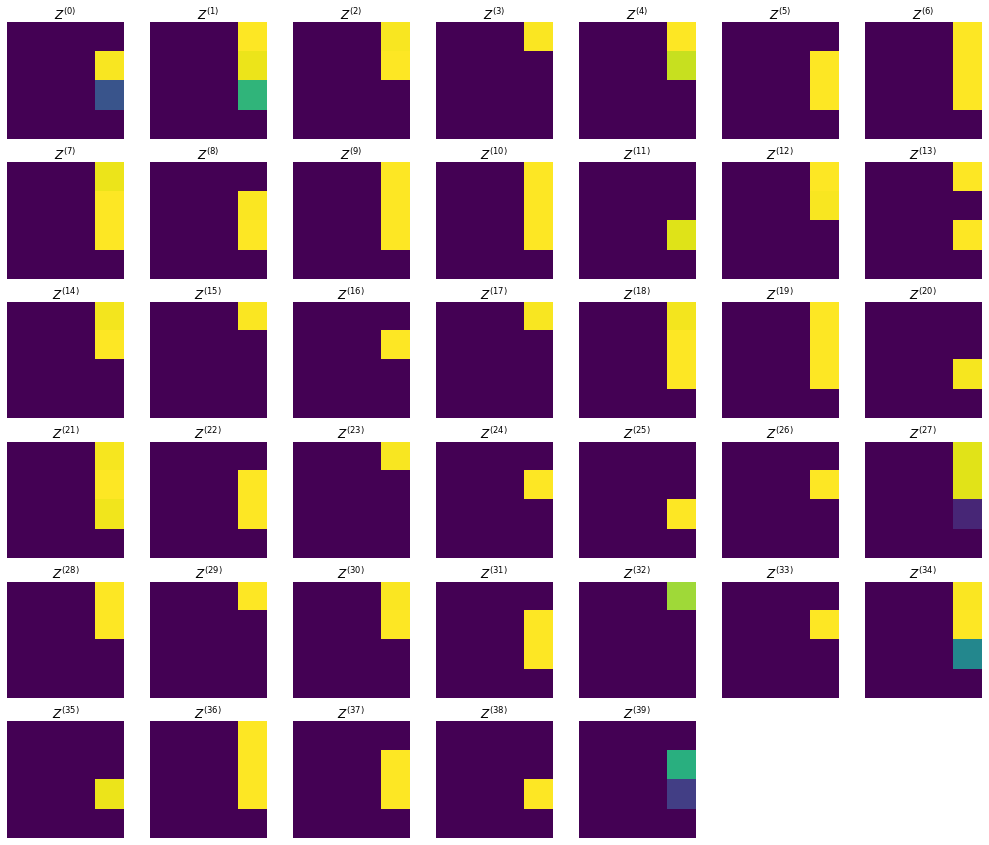

iteration   2000 | alpha  100.0 | beta 2000.0 | #cyclic   0


In [11]:
inter_mask = np.concatenate([np.ones((NUM_SAMPLES, 3)), np.zeros((NUM_SAMPLES, 1))], axis=-1).astype(np.int32)
dibs = JointDiBS(x=data.x, interv_mask=inter_mask, inference_model=inference_model, verbose=True)
key, subk = random.split(key)

gs, theta, z = dibs.sample(key=subk, n_particles=NUM_PARTICLES, steps=2000, callback_every=20, return_z=True, callback=dibs.visualize_callback(), n_dim_particles=PARTICLE_DIM)

### Reshape $\Theta$ for easy use with log likelihood functions later 

In [12]:
def reshape_theta(theta):
    thetas = []
    for k in range(NUM_PARTICLES):
        single_theta = []
        for i in range(len(theta)):
            if len(theta[i]) > 0:
                single_theta.append((theta[i][0][k, ...], theta[i][1][k, ...]))
            else:
                single_theta.append(tuple([]))
        thetas.append(single_theta)
    return thetas

In [13]:
thetas = reshape_theta(theta)

In [14]:
# Compute the log likelihood of a graph given the sampled latent parameters

p_g_z = {}
for name, G in zip(['A', 'B', 'C', 'AB', 'BC', 'CA', 'ABC'], [A, B, C, AB, BC, CA, ABC]):
    p_g_z[name] = np.zeros((NUM_PARTICLES,))
    for i in range(NUM_PARTICLES):
        print(f"log p({name} | Z_{i}) = {dibs.latent_log_prob(G, z[i, ...], t=2000)}")
        p_g_z[name][i] = dibs.latent_log_prob(G, z[i, ...], t=2000)
    print()

log p(A | Z_0) = -26.661062240600586
log p(A | Z_1) = -4.566433906555176
log p(A | Z_2) = -15.214048385620117
log p(A | Z_3) = -0.007811668794602156
log p(A | Z_4) = -2.4513323307037354
log p(A | Z_5) = -101.17520141601562
log p(A | Z_6) = -104.97234344482422
log p(A | Z_7) = -45.31951904296875
log p(A | Z_8) = -66.04301452636719
log p(A | Z_9) = -13.586394309997559
log p(A | Z_10) = -13.77477741241455
log p(A | Z_11) = -58.28547286987305
log p(A | Z_12) = -4.747745990753174
log p(A | Z_13) = -7.558136940002441
log p(A | Z_14) = -7.459266185760498
log p(A | Z_15) = -0.005996946711093187
log p(A | Z_16) = -36.848876953125
log p(A | Z_17) = -0.008259427733719349
log p(A | Z_18) = -71.91480255126953
log p(A | Z_19) = -42.962608337402344
log p(A | Z_20) = -51.528358459472656
log p(A | Z_21) = -18.425527572631836
log p(A | Z_22) = -73.98588562011719
log p(A | Z_23) = -0.0091388039290905
log p(A | Z_24) = -52.31707763671875
log p(A | Z_25) = -64.94001770019531
log p(A | Z_26) = -43.506076812

For each possible hypotheses $G$, find the top-$k$ $Z^{(i)}$'s with the highest log likelihood of generative graph model i.e.,
$$
\argmax_{i \in I, |I| = k} \log p( G | Z^{(i)} )
$$.

In [105]:
I = 10

best_particles = {}
for name, G in zip(['A', 'B', 'C', 'AB', 'BC', 'CA', 'ABC'], [A, B, C, AB, BC, CA, ABC]):
    idx = np.argpartition(p_g_z[name], -I)[-I:][::-1]
    print(f"Top {I} particles for {name}: {idx}")
    best_particles[name] = idx

Top 10 particles for A: [29 15  3  4 23 27 17 32  1 12]
Top 10 particles for B: [ 0 16 24 26 33 39 27 14  2 30]
Top 10 particles for C: [39 38  8 11 35 20 25  0 37 27]
Top 10 particles for AB: [12  2  4 27 28 34 30  1 14 21]
Top 10 particles for BC: [ 0  5 37  8 22 31 39 18  7 21]
Top 10 particles for CA: [27  1 13  9 10 34 21  7 37 29]
Top 10 particles for ABC: [19  6 10 36  7 21  9 18  1 34]


### Mixture Distributions $\log p(G, \Theta | Z^{(i)})$

Form the empirical (i.e., weighted by counts) and mixture distributions (i.e., weighted by unnormalized posterior probabilities, denoted DiBS+).

In [16]:
dibs_empirical = dibs.get_empirical(gs, theta)
dibs_mixture = dibs.get_mixture(gs, theta)
for idx, logp_z in enumerate(dibs_mixture.logp):
	print(f"log p(G, theta | z_{idx}): {logp_z}")

log p(G, theta | z_0): -704.600830078125
log p(G, theta | z_1): -135.164306640625
log p(G, theta | z_2): -181.15185546875
log p(G, theta | z_3): -913.229736328125
log p(G, theta | z_4): -210.488037109375
log p(G, theta | z_5): -529.871337890625
log p(G, theta | z_6): -26.42626953125
log p(G, theta | z_7): -43.32958984375
log p(G, theta | z_8): -511.76123046875
log p(G, theta | z_9): -8.198486328125
log p(G, theta | z_10): -25.019287109375
log p(G, theta | z_11): -1376.410888671875
log p(G, theta | z_12): -181.665283203125
log p(G, theta | z_13): -845.31201171875
log p(G, theta | z_14): -193.9208984375
log p(G, theta | z_15): -922.7001953125
log p(G, theta | z_16): -697.5498046875
log p(G, theta | z_17): -930.822509765625
log p(G, theta | z_18): -33.823974609375
log p(G, theta | z_19): -29.0400390625
log p(G, theta | z_20): -1337.54296875
log p(G, theta | z_21): -0.000244140625
log p(G, theta | z_22): -531.222412109375
log p(G, theta | z_23): -919.531982421875
log p(G, theta | z_24): -6

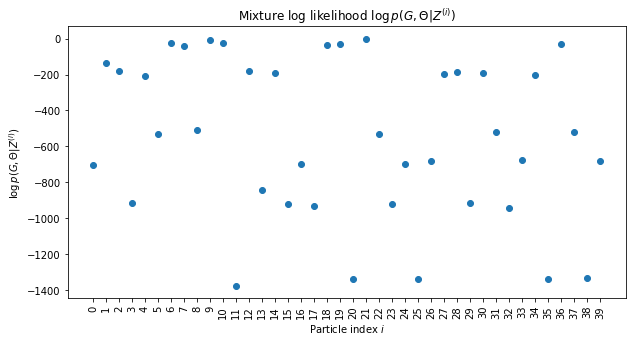

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(np.arange(NUM_PARTICLES), dibs_mixture.logp)
ax.set_xticks(np.arange(NUM_PARTICLES))
ax.set_xticklabels(np.arange(NUM_PARTICLES), rotation=90)
ax.set_xlabel("Particle index "+r"$i$")
ax.set_ylabel(r"$\log p(G, \Theta | Z^{(i)})$")
ax.set_title("Mixture log likelihood " + r"$\log p(G, \Theta | Z^{(i)})$")
plt.show()

## Compute Node embedding similarity

DiBS, similar to Graph Variational Auto-Encoders (GVAE), decomposes the latent variable as $Z = U^\top V$ where $Z \in \mathbb{R}^{d \times d}$, $U \in \mathbb{R}^{d \times K}$, and $V \in \mathbb{R}^{d \times K}$. Here, $d$ is the nodes in the BN and $K$ is an embedding dimension.

Hence, the columns $u_i \in U$ and $v_i \in V$ can be thought of as node embeddings as each entry $g_{i, j}$ in adjacency matrix of $G$ is given by $g_{i, j} = \sigma(v_i^\top u_j)$.

Here, we construct node embedding $n_i$ for node $i$ by concatenating the two column vectors $n_i = [u_i, v_i]$. Then, we compute the cosine distance between the the node embedding with all other nodes, giving us a symmetric matrix $M$ where each entry is given by $m_{i, j} = \frac{n_i \cdot n_j^\top}{ || n_i || \cdot ||n_j||}$.

In [18]:
def m3(u, v):
    grid = np.zeros((NUM_PARTICLES, N_VARS, N_VARS))

    for k in range(NUM_PARTICLES):
        for i in range(N_VARS):
            for j in range(N_VARS):
                Z = jnp.concatenate([u[k, i, :], v[k, i, :]], axis=0)
                Z_norm = jnp.expand_dims(jnp.linalg.norm(Z), axis=0)

                B = jnp.concatenate([u[k, j, :], v[k, j, :]], axis=0).T
                B_norm = jnp.expand_dims(jnp.linalg.norm(B), axis=0)

                cosine_similarity = ((Z @ B.T) / (Z_norm @ B_norm)).T
                cosine_distance = 1 - cosine_similarity
                grid[k, i, j] = cosine_distance
    return grid

def plot_grid(grid, n_cols=7, size=2.5):
    N = grid.shape[0]
    n_rows = N // n_cols
    if N % n_cols:
        n_rows += 1

    plt.rcParams['figure.figsize'] = [size * n_cols, size * n_rows]
    fig, axs = plt.subplots(n_rows, n_cols)
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        if i < N:
            ax.matshow(grid[i, :, :])
            ax.tick_params(axis='both', which='both', length=0)
            ax.set_title(r'$Z^{('f'{i}'r')}$', pad=3)
        ax.tick_params(axis='both', which='both', length=0)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.axis('off')

    plt.show()

### Split $Z$ into $\{U, V\}$ and compute scores $U^\top V$

In [19]:
u, v = z[..., 0], z[..., 1]
scores = jnp.einsum('...ik,...jk->...ij', u, v)

grid = m3(u, v)

Plot similarity grid

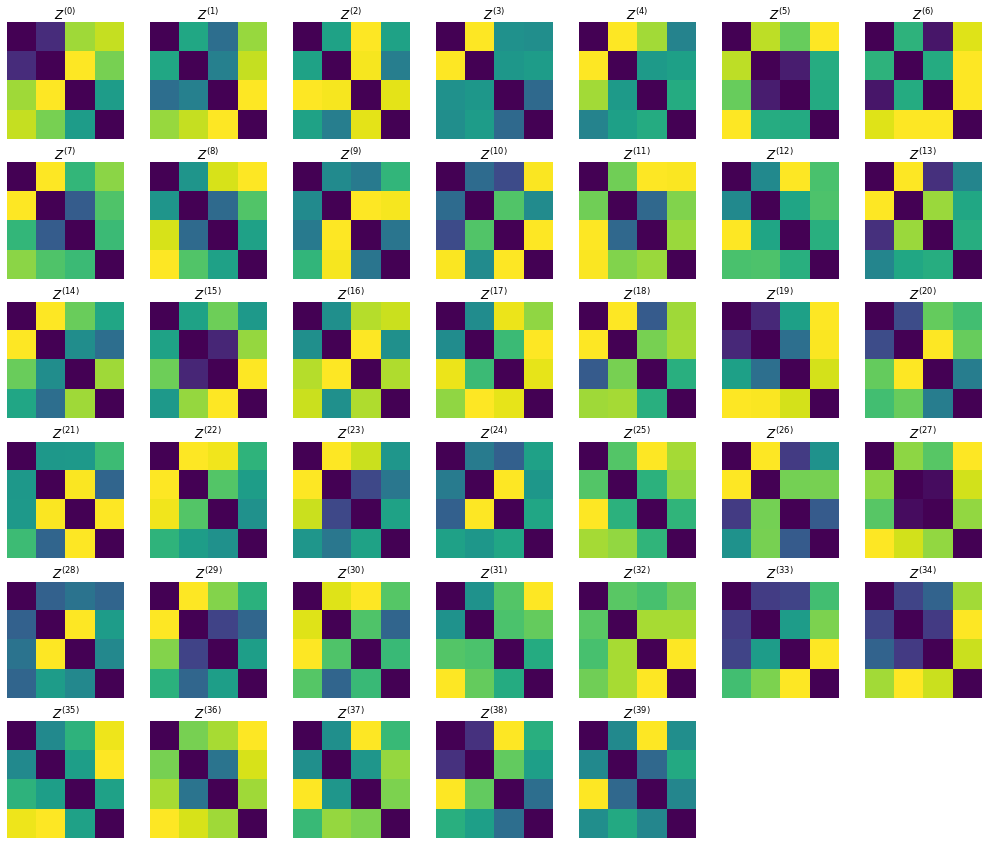

In [20]:
plot_grid(grid)

### Compute some evaluation metrics.

In [21]:
from dibs.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood

for descr, dist in [('DiBS ', dibs_empirical), ('DiBS+', dibs_mixture)]:

    eshd = expected_shd(dist=dist, g=data.g)
    auroc = threshold_metrics(dist=dist, g=data.g)['roc_auc']
    negll = neg_ave_log_likelihood(dist=dist, x=data.x_ho,
                eltwise_log_likelihood=dibs.eltwise_log_likelihood_observ)

    print(f'{descr} |  E-SHD: {eshd:4.1f}    AUROC: {auroc:5.2f}    neg. MLL {negll:5.2f}')

DiBS  |  E-SHD:  1.6    AUROC:  0.93    neg. MLL 23283.45
DiBS+ |  E-SHD:  2.0    AUROC:  0.93    neg. MLL 22718.79


## Investigate Latent particles $Z^{(i)}$

### Projection via UMAP to 2D space

In [22]:
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [23]:
def particle_to_u_v_z_idx(z):
	"""Convert particles Z to components U and V. Stack as single vector.
	Also return particle indices."""
	u, v = z[..., 0], z[..., 1]

	X = np.zeros((NUM_PARTICLES, N_VARS, PARTICLE_DIM*2))
	Y = np.zeros((NUM_PARTICLES, N_VARS, 1))
	Z = np.zeros((NUM_PARTICLES, N_VARS, 1))
	for k in range(NUM_PARTICLES):
		for i in range(N_VARS):
			X[k, i, :] = np.concatenate([u[k, i, :], v[k, i, :]], axis=0)
			Y[k, i, :] = i
			Z[k, i, :] = k
	return X.reshape(-1, PARTICLE_DIM*2), Y.reshape(-1), Z.reshape(-1)

In [24]:
X, Y, Zidx = particle_to_u_v_z_idx(z)

In [25]:
umap_embed = UMAP(n_neighbors=4, n_components=2).fit_transform(X)


Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'callable': Cannot determine Numba type of <class 'builtin_function_or_method'>

File "../../../envs/work/lib/python3.9/site-packages/umap/umap_.py", line 346:
def fuzzy_simplicial_set(X, n_neighbors, metric, metric_kwds={}):
    <source elided>

    if callable(metric):
    ^


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'callable': Cannot determine Numba type of <class 'builtin_function_or_method'>

File "../../../envs/work/lib/python3.9/site-packages/umap/umap_.py", line 346:
def fuzzy_simplicial_set(X, n_neighbors, metric, metric_kwds={}):
    <source elided>

    if callable(metric):
    ^

Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True, but has lifted loops.

File "../../../

In [26]:
def plot_embeddings(embedding, Y, y_labels, label_frmt, method, point_labels=None, filter_=None):
	plt.figure(figsize=(10, 10))
	texts = []
	for y_label in y_labels:
		idx = np.where(Y == y_label)[0]
		plt.scatter(embedding[idx, 0], embedding[idx, 1], s=20, label=label_frmt.format(y_label))

		# Annotate some points in the scatter plot
		if point_labels is not None:

			# for each point plotted
			for i in range(len(embedding[idx, 0])):
				# if that index is to be annotated
				if i in filter_:
					texts.append(
						plt.text(embedding[idx, 0][i], embedding[idx, 1][i], r"$Z^{("+f"{int(point_labels[idx][i])}"+r")}$")
					)

	adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))
	plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
	plt.title(f'Projection of Node Embeddings by {method}')

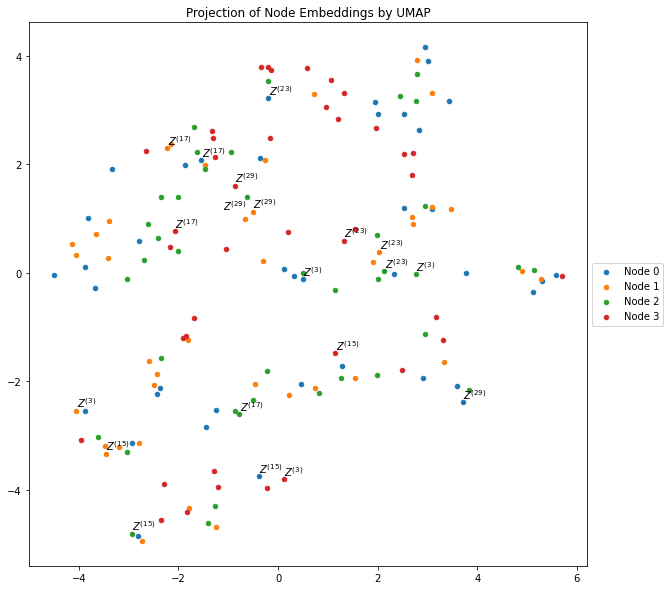

In [27]:
plot_embeddings(umap_embed, Y, y_labels=[i for i in range(N_VARS)], label_frmt="Node {}", method='UMAP', point_labels=Zidx, filter_=best_particles['A'])

In [28]:
tsne_embed = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)

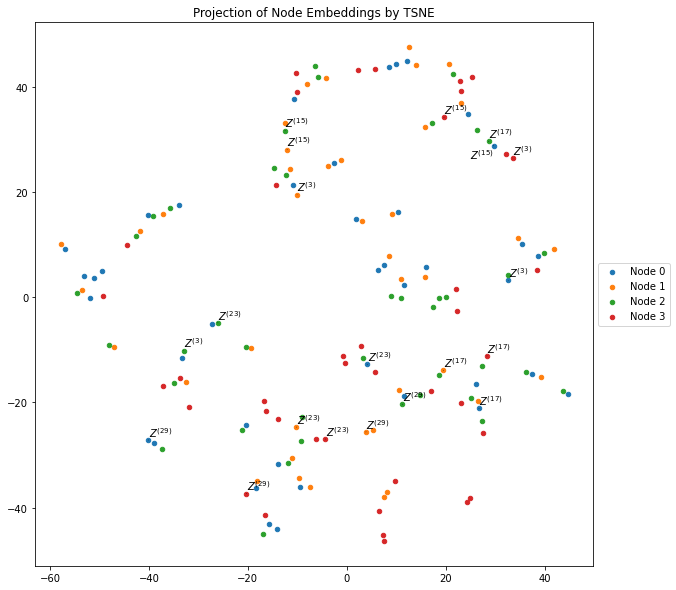

In [29]:
plot_embeddings(tsne_embed, Y, y_labels=[i for i in range(N_VARS)], label_frmt="Node {}", method='TSNE', point_labels=Zidx, filter_=best_particles['A'])

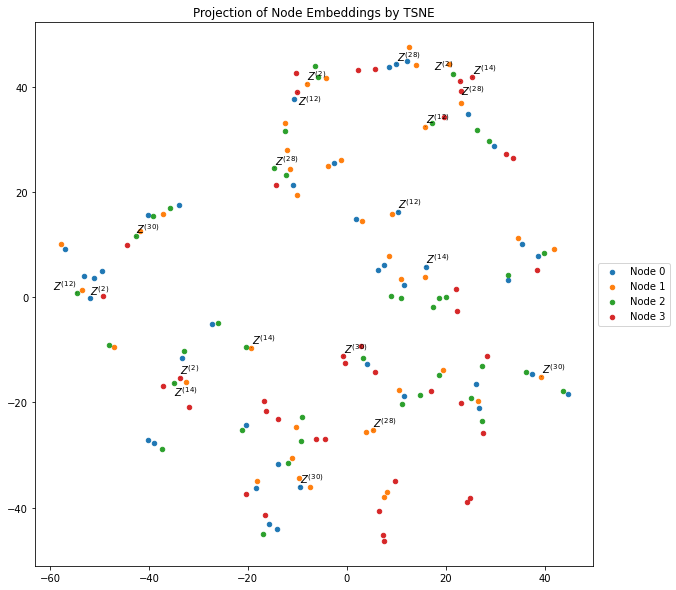

In [30]:
plot_embeddings(tsne_embed, Y, y_labels=[i for i in range(N_VARS)], label_frmt="Node {}", method='TSNE', point_labels=Zidx, filter_=best_particles['AB'])

## Policies based on Latent Variable Model

### Buffer to stack interventions

In [77]:
class NstepHistory:
    """N-step history of intervention data.
    
    Args:
        n_step: number of steps to store.

    Attributes:
        data: numpy array of shape (n_step, n_vars).
    """
    def __init__(self, *, n_step: int) -> None:
        self.n_step = n_step
        self.reset()

    def __call__(self, **kwargs):
        """Update history with new intervention data.
        
        Args:
            state: numpy array of shape (n_vars,).
        """
        if self.data is None:
            self.data = np.tile(deepcopy(kwargs['state']), (self.n_step, 1))
        else:
            self.data = np.roll(self.data, -1, axis=0)
            self.data[-1:, ...] = deepcopy(kwargs['state'])

    def reset(self):
        """Reset history to None."""
        self.data = None

In [78]:
class History:
    """History of intervention data.

    Args:
        n_vars: number of variables.

    Attributes:
        data: numpy array of shape (steps, n_vars).
    """
    def __init__(self, *, n_vars: int) -> None:
        self.n_vars = n_vars
        self.reset()

    def __call__(self, **kwargs):
        """Update history with new intervention data.
        
        Args:
            state: numpy array of shape (n_vars,).
        """
        self.data = np.concatenate([self.data, deepcopy(kwargs['state'][None, ...])], axis=0)

    def reset(self):
        """Reset history to None."""
        self.data = np.empty((0, self.n_vars))

### EGreedyLLPolicy

In [210]:
class EGreedyLLPolicy:
    """Simple math:`\\epsilon`-greedy policy based on maximum log-likelihood math:`\\log p(D | G, \\Theta)`.

    Args:
        inference_model (dibs.inference.Dibs): inference model
        theta (np.ndarray): sampled parameters
        gs (np.ndarray): sampled graphs
        inter_mask (np.ndarray): intervention masks
        action_shape (int): action shape
        n_step (int): number of steps to look behind
        force_exploration (int): number of steps to force exploration,
        buffer (class): buffer to store intervention data
        best_particles (dict): dictionary of best particles for each hypotheses
    """

    def __init__(
        self,
        *,
        inference_model,
        thetas,
        gs,
        inter_mask,
        action_space: int,
        n_step: int,
        force_exploration: int,
        buffer,
        best_particles: dict,
    ) -> None:
        self.inference_model = inference_model
        self.thetas = thetas
        self.gs = gs
        self.inter_mask = jnp.array(inter_mask)
        self.action_space = action_space
        self.n_step = n_step
        self.force_exploration = force_exploration
        self.buffer = buffer
        self.best_particles = best_particles

        self.log_d_g_t = jax.vmap(
            lambda x, single_g, single_theta: self.inference_model.log_likelihood(
                x=x,
                theta=single_theta,
                g=single_g,
                interv_targets=self.inter_mask[: x.shape[0], ...],
            ),
            (None, 0, 0),
            0,
        )

    def __call__(self, *, state: np.ndarray) -> np.ndarray:
        """Perform action given state

        Args:
            state (np.ndarray): state of agent

        Returns:
            np.ndarray: action
        """
        # Perform random intervention if we are in the first few steps
        if self.force_exploration > self.step_cnt:
            self.step_cnt += 1
            return self.action_space.sample()

        else:
            # Update buffer and compute log likelihood of data given sampled parameters
            self.buffer(state=state)

            # Compute the log likelihood of the data given the sampled parameters
            log_d_g_t_list = self.log_d_g_t(jnp.array(self.buffer.data), self.gs, self.thetas)

            mll = np.argmax(log_d_g_t_list)
            # print(f"mll: {mll}")

            # Belief set over hypotheses
            belief_set = []
            for key in self.best_particles:
                if mll in self.best_particles[key]:
                    belief_set.append(key)
            print(f"Belief set: {set(belief_set)}")

            self.step_cnt += 1
            return self.construct_action(set(belief_set), mll)

    def construct_action(self, belief_set, z_idx):
        """Construct action given belief set and particle index

        Args:
            belief_set: Subset of hypotheses that are consistent with the data
            z_idx: Index of particle that maximizes the log likelihood

        Returns:
            action: intervention action
        """
        # pick a random hypothesis from the belief set
        # TODO: 
        hyp = np.random.choice(list(belief_set))
        return self.action_space.sample()

    def reset(self, *args, **kwargs) -> None:
        """Reset policy"""
        self.buffer.reset()
        self.step_cnt = 0


In [211]:
def evaluate_policy(policy, env_config, *, n_episodes: int = 10) -> np.ndarray:
    """Evaluate policy on environment.

    Args:
        policy (dibs.policy.Policy): policy to evaluate
        env_config (dict): experiment configuration of environment
        n_episodes (int, optional): number of episodes to run. Defaults to 10.

    Returns:
        np.ndarray: rewards
    """
    env = CausalEnv_v0(env_config=env_config)

    rewards = []
    for i in range(n_episodes):
        # Reset environment
        obs = env.reset()
        print(f"Current hypotheses: {env._current_gt_hypothesis}")

        # Reset policy
        policy.reset()

        belief_store = []

        # Run episode
        done = False
        while not done:
            # Perform action
            action = policy(state=obs)

            # Step environment
            obs, reward, done, info = env.step(action)

        # Store reward
        rewards.append(reward)

    return np.array(rewards)

In [212]:
def read_experiment_config(path: str) -> dict:
    """Read experiment configuration from file.

    Args:
        path (str): path to experiment configuration file

    Returns:
        dict: experiment configuration
    """
    with open(path, "r") as f:
        exp_config = EasyDict(yaml.load(f, Loader=yaml.FullLoader))
        ldict = {}
        exec(exp_config.env.hypotheses, globals(), ldict)
        exp_config.env.hypotheses = ldict["hypotheses"]

    return exp_config

In [213]:
exp_config = read_experiment_config("config/exp_config.yaml")

policy = EGreedyLLPolicy(
    inference_model=dibs.inference_model,
    thetas=theta,
    gs=gs,
    inter_mask=inter_mask,
    action_space=env.action_space,
    n_step=5,
    force_exploration=5,
    buffer=History(n_vars=env.observation_space.shape[0]),
    best_particles=best_particles,
)

In [214]:
rewards = evaluate_policy(policy, exp_config['env'], n_episodes=exp_config.get("n_episodes", 10))

Current hypotheses: <class 'causal_env_v0.Cdisj'>
Belief set: {'CA'}
Belief set: {'C'}
Belief set: {'C'}
Belief set: {'C'}
Belief set: {'C'}
Belief set: {'C'}
Belief set: {'C'}
Belief set: {'CA'}
Belief set: {'C'}
Belief set: {'C'}
Belief set: {'C'}
Belief set: {'C'}
Belief set: {'C'}
Belief set: {'C'}
Belief set: {'C'}
Belief set: {'C'}
Belief set: {'C'}
